In [26]:
# pip install librosa

In [27]:
#The output of this section is the CSV files with the data to be handle by the model
CREATE_CSV_FILES = True

In [28]:
# Defines the names of the CSV files
TRAIN_CSV_FILE = "Speaker_Train_File_otw2.csv"    # train  60
TEST_CSV_FILE = "Speaker_Test_File_otw2.csv"      # test 16

In [29]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
from matplotlib import cm
import pandas as pd
import librosa
import zipfile as zf
import csv
import os
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import csv
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.mixture import GaussianMixture

In [30]:
def extractWavFeatures(soundFilesFolder, csvFileName):
    print("The features of the files in the folder "+soundFilesFolder+" will be saved to "+csvFileName)
    header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'  
    for i in range(1, 41):
        header += f' mfcc{i}'  #making headers of csv file
    header += ' label'     
    header = header.split()
    print('CSV Header: ', header)
    file = open(csvFileName, 'w', newline='')
    #with file:
    writer = csv.writer(file)
    writer.writerow(header)
    for filename in os.listdir(soundFilesFolder):
        if filename.endswith('.wav'):
            number = f'{soundFilesFolder}/{filename}'
            y, sr = librosa.load(number, mono=True, duration=30)
            # remove leading and trailing silence
            y, index = librosa.effects.trim(y)
            chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
            rmse = librosa.feature.rms(y=y)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            zcr = librosa.feature.zero_crossing_rate(y)
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 40)
            to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
            for e in mfcc:
                to_append += f' {np.mean(e)}'
            writer.writerow(to_append.split())
    file.close()
    print("End of extractWavFeatures")

In [31]:
if (CREATE_CSV_FILES == True):
    extractWavFeatures("Speaker_Train_Data", TRAIN_CSV_FILE)
    extractWavFeatures("Speaker_Test_Data", TEST_CSV_FILE)
    print("CSV files are created")
else:
    print("CSV files creation is skipped")

The features of the files in the folder training_set will be saved to Speaker_Train_File_otw2.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'label']
End of extractWavFeatures
The features of the files in the folder Speaker_Test_Data will be saved to Speaker_Test_File_otw2.csv
CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mf

In [32]:
#Reading a dataset and convert file name to corresbonding umnber
def preProcessData(csvFileName):
    header_name_list = ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40', 'label']
    print(csvFileName+ " will be preprocessed")
    data =  pd.read_csv(csvFileName)
#     data = pd.read_csv(csvFileName, skiprows=[1, 50]
    # we have 3 speakers: 
    # 0: ahmed
    # 1: belal
    # 2: micheal
    # 3: others
    filenameArray = data['filename'] 
    speakerArray = []
#     print(filenameArray)
    lengthOfSpeakerSamples = [0,0,0,0]
    for filename in filenameArray:
        #print(speaker)
        if "OTW" in filename:
            speaker = 0
        elif "OTD" in filename:
            speaker = 1
        elif "CTD" in filename:
               speaker = 2
        else: 
            speaker = 3
        lengthOfSpeakerSamples[speaker]+=1
#         print(speaker)
        speakerArray.append(speaker)
    print(lengthOfSpeakerSamples)
    data['number'] = speakerArray
    #Dropping unnecessary columns
    data = data.drop(['filename'],axis=1)
    data = data.drop(['label'],axis=1)
    data = data.drop(['chroma_stft'],axis=1)
    for i in range(1, 41):
        data = data.drop([f' mfcc{i}'],axis=1)
#     data.shape
    print("Preprocessing is finished")
#     print(data['rmse'])
    print(data)
    return data

In [33]:
trainData = preProcessData(TRAIN_CSV_FILE)
testData = preProcessData(TEST_CSV_FILE)

Speaker_Train_File_otw2.csv will be preprocessed
         rmse  spectral_centroid  spectral_bandwidth      rolloff  \
0    0.015968        1484.444239         1552.483728  2645.490133   
1    0.016634        1396.814884         1539.317690  2477.184638   
2    0.018314        1465.592499         1532.553671  2578.910459   
3    0.019000        1474.477504         1575.985550  2673.211039   
4    0.020263        1531.649987         1582.545651  2759.838867   
..        ...                ...                 ...          ...   
291  0.014330        1256.363929         1407.134373  2270.267881   
292  0.010075        1185.632158         1367.412051  2081.295461   
293  0.013756        1108.288493         1319.804104  1898.263234   
294  0.011683        1173.559591         1355.675149  1955.437601   
295  0.013097        1114.507464         1309.830857  1908.039803   

     zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  \
0              0.117900 -471.342407  121.971107  

In [34]:
testData

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40,number
0,0.009993,1222.905682,1460.351945,2157.293701,0.060233,-533.275513,126.323990,-5.393278,7.978744,-1.688960,...,9.847920,6.317571,2.457523,2.565717,-0.549338,-1.875484,-0.544401,-0.735906,-3.623948,3
1,0.016585,1230.753953,1509.360576,2346.060131,0.049973,-485.665253,118.747414,-0.341144,14.197672,-8.606584,...,5.284318,7.979311,1.586594,2.322874,-2.114764,-1.790100,-0.101661,0.374472,-1.964005,3
2,0.013829,1166.165148,1480.120271,2109.620577,0.050800,-504.032043,127.963150,2.349404,14.097299,-8.987041,...,3.478289,7.570534,2.271217,2.971118,0.029042,-0.701853,1.432102,0.208487,-3.162876,3
3,0.015517,1387.471357,1609.152266,2662.320683,0.058013,-501.029175,112.742699,-15.422599,16.566858,-6.766524,...,4.116170,4.058353,1.534295,1.178144,-1.235215,1.639595,-3.728315,-2.688532,-1.636350,3
4,0.015835,1276.583495,1634.214861,2637.144470,0.039693,-499.826416,122.048950,-1.920735,24.336123,-6.788704,...,10.266263,15.390595,9.012878,7.133364,0.400037,-0.292058,-4.085672,0.174606,5.223323,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,0.042985,1814.419202,2068.841427,3832.619167,0.078574,-434.496246,112.916397,14.558284,19.883001,2.654404,...,-2.922314,-5.019325,-4.526140,-4.617517,-4.716003,-5.655179,-4.306020,-4.753742,-3.474115,3
89,0.036381,1995.008828,2102.141285,3936.269531,0.079740,-454.976349,100.731712,16.845055,20.575390,12.396941,...,-4.975369,-5.245577,-4.434406,-6.300651,-4.143828,-4.713008,-3.595579,-6.107916,-2.948173,3
90,0.030267,2145.997022,2248.043801,4451.083646,0.099725,-495.136993,88.907974,21.396997,20.355251,9.377746,...,-5.482361,-4.185727,-4.232754,-5.212183,-2.876807,-3.669876,-4.746403,-4.561175,-1.552745,3
91,0.029816,2035.026065,2295.683010,4361.697110,0.084806,-481.398621,98.354515,25.813599,17.567360,14.787317,...,-3.813303,-4.131896,-3.526616,-5.430199,-3.725750,-3.397746,-3.936089,-5.319873,-2.225244,3


In [35]:
# Splitting the dataset into training, validation and testing dataset

X = trainData[trainData.columns[:-1]]
y = trainData[trainData.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41 )


# X_test = np.array(testData.iloc[:, :-1], dtype = float)
# y_test = testData.iloc[:, -1]

#X_test = X_val
#y_test = y_val
print("Y from training data:", y_train.shape)
print("Y from validation data:", y_test.shape)
print("Y from test data:", y_test.shape)

Y from training data: (222,)
Y from validation data: (74,)
Y from test data: (74,)


In [36]:
X_train

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,...,mfcc31,mfcc32,mfcc33,mfcc34,mfcc35,mfcc36,mfcc37,mfcc38,mfcc39,mfcc40
151,0.012478,1257.624552,1425.710417,2170.522124,0.103645,-527.298157,141.043121,14.439873,9.306044,-8.277680,...,-7.402061,-2.928041,-4.111814,-7.414955,-5.522139,-2.119271,-0.407125,-3.588601,-4.472240,-6.519820
220,0.015437,1160.183610,1328.682088,2068.177532,0.093974,-511.368896,157.948502,6.366711,6.532806,-1.312892,...,-10.202747,-5.199558,-5.703609,-3.225093,-6.447236,-5.742431,-5.162983,-7.985875,-6.143374,-4.779424
287,0.013509,1076.216843,1308.529701,1800.868804,0.088390,-538.773560,149.786484,19.628086,14.608000,5.255319,...,-8.045302,-5.081237,-4.886742,-6.645554,-6.809140,-5.043016,-4.562056,-5.553207,-6.012231,-5.221018
25,0.022790,1461.809739,1537.421521,2529.780105,0.105867,-463.759521,117.063667,3.483767,1.683621,-4.287273,...,-10.449944,-6.767702,-1.853322,-6.454459,-6.394603,-6.240014,-6.541639,-5.534691,-2.668429,-0.143334
208,0.013920,1372.819209,1483.275669,2632.867221,0.103763,-495.463287,153.283691,-5.922596,7.217886,1.167865,...,-10.074771,-4.156942,-4.795500,-3.784593,-6.561153,-6.851946,-4.800919,-5.517815,-6.408363,-7.144804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,0.014825,1069.779048,1274.183839,1839.108803,0.089058,-523.004028,155.486343,10.643128,8.174256,12.590116,...,-5.580099,-4.449925,-3.089257,-4.664872,-7.146196,-6.316271,-5.283483,-4.464484,-5.859414,-6.517493
282,0.011737,1138.657296,1317.901682,1904.945952,0.092089,-542.287781,154.646118,12.063504,12.479855,4.047681,...,-8.437263,-7.294569,-3.359636,-5.781694,-7.310534,-6.120831,-4.494345,-5.022580,-6.190376,-4.041655
89,0.023261,1320.076303,1479.371696,2355.410661,0.098246,-462.735901,111.464684,10.618321,6.532448,-2.816582,...,-7.678272,-5.693685,-4.482268,-5.339853,-6.279514,-3.719343,-4.643056,-4.605392,-0.012951,2.032291
243,0.011989,1112.418412,1254.910382,1917.568864,0.093144,-536.654053,159.233032,6.789628,3.592778,4.467918,...,-5.213067,-3.631777,-2.625592,-3.649685,-8.705916,-6.036429,-3.527526,-6.480385,-5.985373,-3.881156


In [37]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler, normalize
import numpy as np
#scaler = StandardScaler()
#X_train = scaler.fit_transform( X_train )
#X_test = scaler.transform( X_test )
#X_train = normalize(X_train)
#X_test = normalize (X_test)
print("X from training data", X_train.shape)
print("X from test data", X_test.shape)

X from training data (222, 45)
X from test data (74, 45)


In [38]:

X_train.shape

(222, 45)

In [39]:
# gmm=GaussianMixture(n_components=6, max_iter=200 , covariance_type="diag" , n_init=3)
# gmm.fit(X_train)

In [40]:
#Create an object (model)
dtr1 = DecisionTreeClassifier(max_depth =7, random_state = 10)
#Fit (train) the model

#X_train = X_train.astype('int')

#y_train=y_train.astype('int')


dtr1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=10)

In [41]:
np.unique(y_train  ,return_counts = True)


(array([0, 1, 2, 3], dtype=int64), array([53, 55, 60, 54], dtype=int64))

In [42]:
np.unique(y_test  ,return_counts = True)


(array([0, 1, 2, 3], dtype=int64), array([21, 20, 12, 21], dtype=int64))

In [43]:
pd.DataFrame(X_train)[pd.DataFrame(X_train).columns[3:9]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222 entries, 151 to 80
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rolloff             222 non-null    float64
 1   zero_crossing_rate  222 non-null    float64
 2   mfcc1               222 non-null    float64
 3   mfcc2               222 non-null    float64
 4   mfcc3               222 non-null    float64
 5   mfcc4               222 non-null    float64
dtypes: float64(6)
memory usage: 12.1 KB


In [44]:
# #plt the figure, setting a black background
# plt.figure(figsize=(30,10))
# #create the tree plot
# a = tree.plot_tree(dtr1,feature_names = list(['rmse', 'spectral_centroid', 'spectral_bandwidth', 
#                    'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 
#                    'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 
#                    'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25', 'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc30', 
#                    'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36', 'mfcc37', 'mfcc38', 'mfcc39', 'mfcc40']),
#                    class_names = ["0", "1","4"],
#                    rounded = True,
#                    filled = True,
#                    fontsize=14)
# #show the plot
# plt.show()

In [45]:
# data = preProcessData('Speaker_File.csv')
test_pred_decision_tree = dtr1.predict(X_test)

print(test_pred_decision_tree)
print(np.array(y_test))


[0 1 3 0 1 0 2 3 1 3 1 1 2 0 3 2 3 0 3 2 1 0 3 0 3 1 1 0 2 0 1 2 3 3 0 0 3
 2 1 2 1 0 1 0 0 1 0 3 0 2 3 1 2 1 0 0 0 3 0 3 0 2 2 1 0 1 3 1 1 1 2 2 3 3]
[0 1 3 0 1 0 2 3 0 3 1 1 2 0 3 2 3 0 3 2 1 3 3 0 3 1 1 1 2 0 1 2 1 3 0 0 3
 1 1 2 0 0 1 3 0 1 3 3 2 0 0 1 3 1 3 0 0 0 0 3 3 2 2 1 0 1 2 1 1 0 2 3 3 3]


In [46]:
y_test=y_test.astype('int64')

print("Accuracy:",metrics.accuracy_score(y_test, test_pred_decision_tree))

Accuracy: 0.7567567567567568


In [47]:
def report(X_data, y_data):
    #Confution Matrix and Classification Report
    Y_pred = dtr1.predict(X_data)
    y_test_num = y_data.astype(np.int64)
    conf_mt = confusion_matrix(y_test_num, Y_pred)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    # target_names = ["Marina", "Mohab", "Unknown"]
    print(classification_report(y_test_num, Y_pred))

Classification Report for Test Data

[[15  3  1  2]
 [ 1 17  1  1]
 [ 1  0 10  1]
 [ 5  0  2 14]]


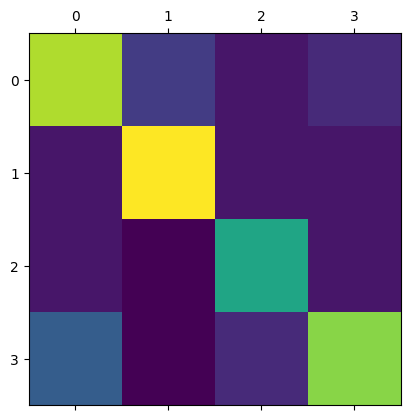


Classification Report
              precision    recall  f1-score   support

           0       0.68      0.71      0.70        21
           1       0.85      0.85      0.85        20
           2       0.71      0.83      0.77        12
           3       0.78      0.67      0.72        21

    accuracy                           0.76        74
   macro avg       0.76      0.77      0.76        74
weighted avg       0.76      0.76      0.76        74



In [48]:
print("Classification Report for Test Data\n")
report(X_test, y_test)

In [49]:
# save the model to disk
import pickle
filename = 'sentene.sav'
pickle.dump(dtr1, open(filename, 'wb'))


# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

In [50]:
loaded_model =pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
result

0.7567567567567568